
# Network Intrusion Detection Using Machine Learning

This notebook demonstrates the use of three machine learning techniques - K-means clustering, Random Forest, and Isolation Forest - for network intrusion detection.
We will evaluate the models using metrics such as accuracy, precision, recall, F1-score, ROC-AUC, and a confusion matrix. On a scale from 0 to 1, a number closer to 1 indicates a model that more accurately predicts the data.

**Dataset**: The [CICIDs 2017 dataset](https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset) represents network traffic data, with the "Label" column indicating whether traffic is BENIGN or represents an attack.


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a list to store DataFrames
data_frames = []

# File paths for each dataset
file_paths = [
    '../data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 
    '../data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 
    '../data/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    '../data/Monday-WorkingHours.pcap_ISCX.csv',
    '../data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    '../data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    '../data/Tuesday-WorkingHours.pcap_ISCX.csv',
    '../data/Wednesday-workingHours.pcap_ISCX.csv',
]

# Index to keep track of files
index = 0

# Load each file using a while loop and append to data_frames
while index < len(file_paths):
    df = pd.read_csv(file_paths[index])
    data_frames.append(df)
    index += 1

# Concatenate all dataframes in the list into a single dataframe
combined_data = pd.concat(data_frames, ignore_index=True)

# Check the combined data
print(f"Combined data length: {len(combined_data)}")
combined_data.head()

Combined data length: 2830743


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Data Preprocessing

The data preprocessing step combines raw network traffic data from multiple sources into a unified dataset with features such as packet size, protocol, and flags. This process ensures the dataset is well-prepared for machine learning algorithms by:

* Handling Missing Values: Cleans the data by filling or removing any missing information to maintain data integrity.
    
* Encoding Labels: Converts categorical labels into a numerical format suitable for model training.
    
* Scaling Features: Normalizes features for consistency, which enhances model performance, especially in distance-based algorithms.
    
* Splitting Data: Divides the dataset into training and testing sets (X_train, X_test, y_train, y_test), setting up the data for model evaluation.

These steps produce a refined dataset that’s ready for training and testing, ensuring each model has clean and standardized inputs.



In [18]:
# combined_data Preprocessing

# Dropping any rows with missing values
combined_data.dropna(inplace=True)

# Strip any leading or trailing whitespace from column names
combined_data.columns = combined_data.columns.str.strip()

# Label Encoding the target variable
label_encoder = LabelEncoder()
combined_data['Label'] = label_encoder.fit_transform(combined_data['Label'])

# Splitting combined_data into features and target
X = combined_data.drop(columns=['Label'])
y = combined_data['Label']

# Replace infinite values with NaN, then replace NaNs with the median of each column
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Scaling the features for better performance in clustering algorithms
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# **K-means Clustering**
K-means provides a moderate accuracy of 81.73%, reflecting reasonable clustering of normal and anomalous data points.

The model performs well in terms of precision (84.54%) and recall (81.74%), indicating its ability to accurately identify clusters, though it still misclassifies some data.

With an F1-score of 77.06%, K-means shows a balanced performance but may struggle with complex boundary cases in anomaly detection due to its unsupervised nature.

Overall, K-means clustering can serve as an initial clustering method but might benefit from more sophisticated algorithms for nuanced classifications.


In [21]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize and train K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

# Predict clusters on the test set
y_kmeans_pred = kmeans.predict(X_test)

# Map cluster labels to actual labels
# Create a DataFrame with predictions and true labels
results_df = pd.DataFrame({'Cluster': y_kmeans_pred, 'TrueLabel': y_test})

# Determine the majority label for each cluster
label_mapping = results_df.groupby('Cluster')['TrueLabel'].agg(lambda x: x.value_counts().index[0])

# Replace cluster labels with mapped labels
mapped_predictions = np.array([label_mapping[label] for label in y_kmeans_pred])

# Evaluate the mapped predictions
print("K-means Clustering Evaluation:")
print("Accuracy:", accuracy_score(y_test, mapped_predictions))
print("Precision:", precision_score(y_test, mapped_predictions, average='weighted', zero_division=1))
print("Recall:", recall_score(y_test, mapped_predictions, average='weighted'))
print("F1-score:", f1_score(y_test, mapped_predictions, average='weighted'))


K-means Clustering Evaluation:
Accuracy: 0.8173809164765979
Precision: 0.8454451257141543
Recall: 0.8173809164765979
F1-score: 0.7705897988150698


# **Random Forest Classifier**
The Random Forest model achieves exceptionally high accuracy (99.88%), precision (99.87%), and recall (99.88%), demonstrating its ability to accurately classify nearly all normal and anomalous data points.

The high F1-score (99.87%) reflects excellent balance, handling both false positives and false negatives effectively.
 
This model is robust and reliable for this dataset, excelling at distinguishing normal from anomalous traffic.

Overall, Random Forest stands out as the most effective model for this network intrusion detection task, achieving near-perfect results.


Random Forest Evaluation:
Accuracy: 0.9987523797854895
Precision: 0.9986912183096852
Recall: 0.9987523797854895
F1-score: 0.9986895350847652


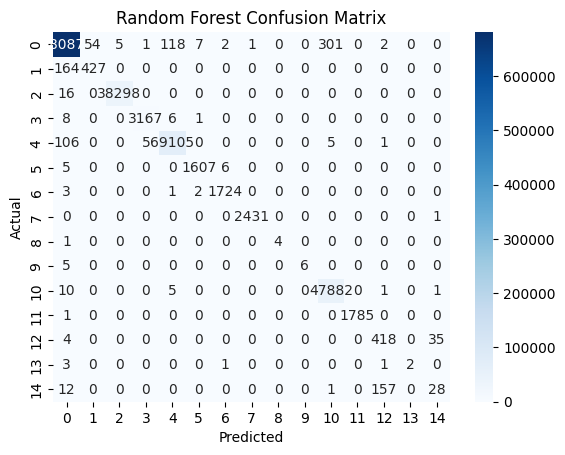

In [23]:
# Random Forest Classifier

# Initialize and train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate Random Forest on test set
y_rf_pred = rf.predict(X_test)

# Evaluating Random Forest
print("Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_rf_pred))
print("Precision:", precision_score(y_test, y_rf_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_rf_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_rf_pred, average='weighted'))
# print("ROC-AUC:", roc_auc_score(y_test, y_rf_pred))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# **Isolation Forest**

With an accuracy of 74.87%, the Isolation Forest model offers moderate performance in anomaly detection, with some room for improvement.

Precision (66.78%) and F1-score (70.59%) reveal that the model sometimes predicts normal data as anomalies, leading to a higher rate of false positives.

The recall of 74.87% indicates it can detect most anomalies but is less consistent compared to Random Forest.
 
Overall, Isolation Forest is useful as a quick, unsupervised anomaly detector but is less accurate and precise for this dataset. It might be better suited as a supplementary model or in scenarios where labeled data isn’t available.


Isolation Forest Evaluation:
Accuracy: 0.748664021413357
Precision: 0.8643721280131701
Recall: 0.748664021413357
F1-score: 0.7059122530932198


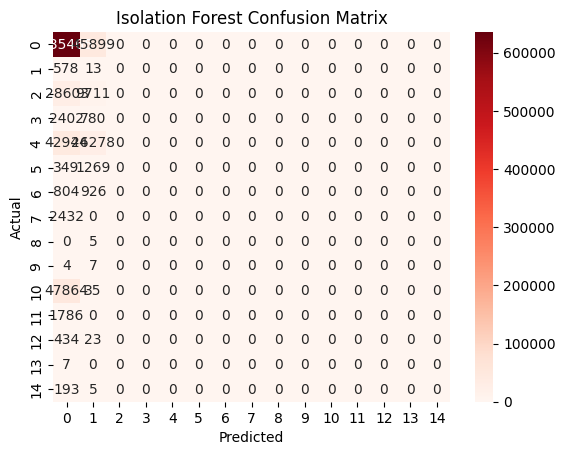

In [25]:
# Isolation Forest

# Initialize and train Isolation Forest
isolation_forest = IsolationForest(random_state=42, contamination=0.1)
isolation_forest.fit(X_train)

# Predict and evaluate Isolation Forest on test set
y_iso_pred = isolation_forest.predict(X_test)
# Adjust predictions: Isolation Forest labels anomalies as -1 and normal as 1, convert to match our target encoding
y_iso_pred = np.where(y_iso_pred == 1, 0, 1)

# Evaluating Isolation Forest
print("Isolation Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_iso_pred))
print("Precision:", precision_score(y_test, y_iso_pred, average='weighted', zero_division=1))
print("Recall:", recall_score(y_test, y_iso_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_iso_pred, average='weighted'))
# print("ROC-AUC:", roc_auc_score(y_test, y_iso_pred))

# Confusion Matrix
cm_iso = confusion_matrix(y_test, y_iso_pred)
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Reds')
plt.title('Isolation Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# **Final Recommendation**
Among the three models, Random Forest clearly performs the best, achieving near-perfect classification and excelling in all evaluation metrics.

If computational resources allow, it is recommended to deploy Random Forest as the primary model for network intrusion detection.
 
K-means and Isolation Forest may be useful in situations where unsupervised learning is required or as secondary checks, but they do not match the precision and reliability of Random Forest for this dataset.